In [1]:
# Standard Library
import itertools
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

# Numerical Analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statsmodels
import statsmodels.api as sm
from statsmodels.api import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# scikit-learn
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

# XGBoost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Matplotlib Configuration
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({
    # Figure Aesthetics
    'figure.figsize': (8, 5),
    'figure.facecolor': 'white',
    
    # Axes and Grid
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'axes.grid.which': 'major',
    'grid.color': 'lightgray',
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,

    # Spines (Borders)
    'axes.spines.top': False,
    'axes.spines.right': False,
    
    # Ticks and Tick Labels
    'xtick.bottom': True,
    'xtick.major.size': 3,
    'xtick.minor.size': 0,
    'ytick.left': True,
    'ytick.major.size': 3,
    'ytick.minor.size': 0,

    # Fonts and Text
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans', 'Lucida Grande', 'Verdana'],
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,

    # Lines and Markers
    'lines.linewidth': 1.5,
    'lines.markersize': 5,

    # Colors
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'axes.titlecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
})

# Utils (commented out as not being used, but can be uncommented as needed)
# from ts_utils import load_and_clean_air_traffic, \
#     lag_plots, \
#     decompose_series, \
#     perform_adf_test, \
#     perform_kpss_test


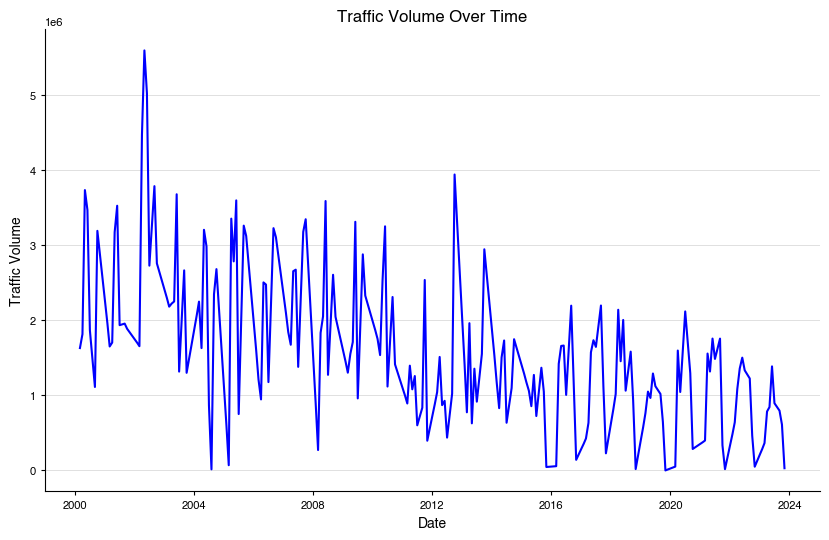

In [2]:
# Load the dataset
data_path = "../data/processed_data_monthly.csv"
modeling_data = pd.read_csv(data_path)

# Convert 'timestamp' to datetime format
modeling_data['timestamp'] = pd.to_datetime(modeling_data['timestamp'])

prophet_data = modeling_data[['timestamp', 'all_motor_vehicles']].rename(columns={'timestamp': 'ds', 'all_motor_vehicles': 'y'})

plt.figure(figsize=(10, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], color='blue')
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.show()


In [3]:
# Train/Test Split
ptrain = prophet_data.loc[prophet_data['ds'] <= "2020-12-01"]
ptest = prophet_data.loc[prophet_data['ds'] > "2020-12-01"]

print(f"Train size: {len(ptrain)}, Test size: {len(ptest)}")


Train size: 250, Test size: 35


## Model 1: Naive Model (Baseline)

In [4]:
from sklearn.metrics import mean_absolute_percentage_error


Naive Model MAE: 552798.7
Naive Model MAPE: 146.86%


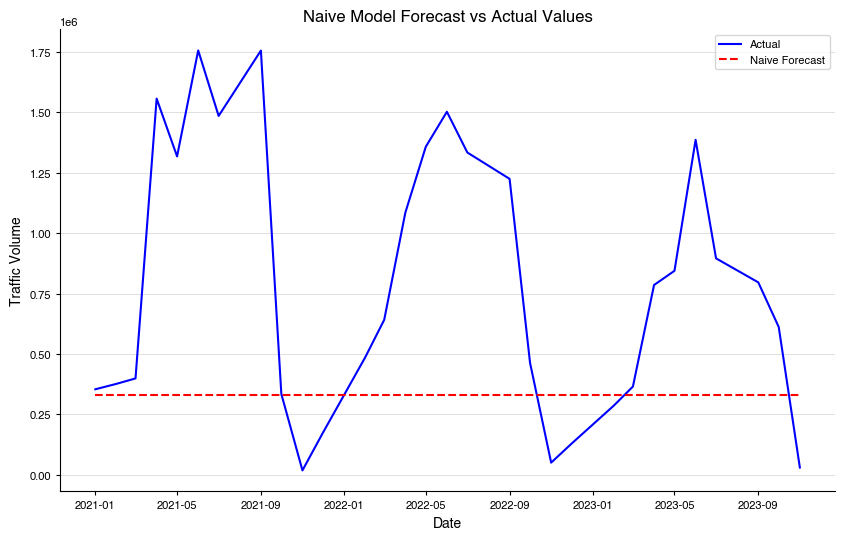

In [5]:
# Naive Model: Last Observation Carried Forward
naive_forecast = ptrain['y'].iloc[-1]  # Last observation from the training set

# Apply the naive forecast to the test set
ptest['naive_forecast'] = naive_forecast

# Evaluate Naive Model
mae_naive = mean_absolute_error(ptest['y'], ptest['naive_forecast'])
mape_naive = mean_absolute_percentage_error(ptest['y'], ptest['naive_forecast'])

print(f"Naive Model MAE: {mae_naive}")
print(f"Naive Model MAPE: {mape_naive * 100:.2f}%")

# Plot Naive Forecast vs Actual
plt.figure(figsize=(10, 6))
plt.plot(ptest['ds'], ptest['y'], label='Actual', color='blue')
plt.plot(ptest['ds'], ptest['naive_forecast'], label='Naive Forecast', color='red', linestyle='--')
plt.title('Naive Model Forecast vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


## Model 2: Prophet Baseline Model

In [6]:
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])

In [7]:
ptrain = prophet_data.loc[prophet_data['ds'] <= "2020-12-01", :]
ptest = prophet_data.loc[prophet_data['ds'] > "2020-12-01", :]

In [8]:
print(ptest['ds'].head())


250   2021-01-01
251   2021-02-01
252   2021-03-01
253   2021-04-01
254   2021-05-01
Name: ds, dtype: datetime64[ns]


In [9]:
baseline_model = Prophet()
baseline_model.fit(ptrain)

future = baseline_model.make_future_dataframe(periods=len(ptest), freq='M')  # Predict for months
forecast = baseline_model.predict(future)


03:46:16 - cmdstanpy - INFO - Chain [1] start processing
03:46:16 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-03-01,2.625330e+06,1.138757e+06,2.830715e+06,2.625330e+06,2.625330e+06,-635986.585847,-635986.585847,-635986.585847,-635986.585847,-635986.585847,-635986.585847,0.0,0.0,0.0,1.989343e+06
1,2000-04-01,2.617454e+06,1.832022e+06,3.487869e+06,2.617454e+06,2.617454e+06,45633.812367,45633.812367,45633.812367,45633.812367,45633.812367,45633.812367,0.0,0.0,0.0,2.663087e+06
2,2000-05-01,2.609832e+06,2.103053e+06,3.883091e+06,2.609832e+06,2.609832e+06,428572.582775,428572.582775,428572.582775,428572.582775,428572.582775,428572.582775,0.0,0.0,0.0,3.038404e+06
3,2000-06-01,2.601956e+06,2.595253e+06,4.325517e+06,2.601956e+06,2.601956e+06,853679.284214,853679.284214,853679.284214,853679.284214,853679.284214,853679.284214,0.0,0.0,0.0,3.455635e+06
4,2000-07-01,2.594334e+06,1.302025e+06,3.038722e+06,2.594334e+06,2.594334e+06,-431597.857032,-431597.857032,-431597.857032,-431597.857032,-431597.857032,-431597.857032,0.0,0.0,0.0,2.162736e+06


In [11]:
# Merge forecast data with test data based on 'ds'
ptest = ptest.merge(forecast[['ds', 'yhat']], on='ds', how='left')

# Rename 'yhat' to 'prophet_forecast'
ptest.rename(columns={'yhat': 'prophet_forecast'}, inplace=True)


In [12]:

print(ptest.isna().sum())  # Check for NaN values
print(np.isinf(ptest).sum())  # Check for infinite values


ds                   0
y                    0
prophet_forecast    35
dtype: int64
ds                  0
y                   0
prophet_forecast    0
dtype: int64


In [13]:
# Interpolate missing values in the 'prophet_forecast' column
ptest['prophet_forecast'] = ptest['prophet_forecast'].interpolate(method='linear')

# Check if there are still NaN values after interpolation
print(ptest['prophet_forecast'].isna().sum())  # Should now be 0

35


In [14]:
print(ptest.shape)


(35, 3)


In [15]:
print(ptest['prophet_forecast'].isna().sum())


35


In [17]:
# Check for NaN values after interpolation
print(ptest['prophet_forecast'].isna().sum())

35


In [21]:
# Check for zero values in actuals (y)
zero_values_count = ptest['y'].eq(0).sum()
print(f"Number of zero values in actuals: {zero_values_count}")


Number of zero values in actuals: 0


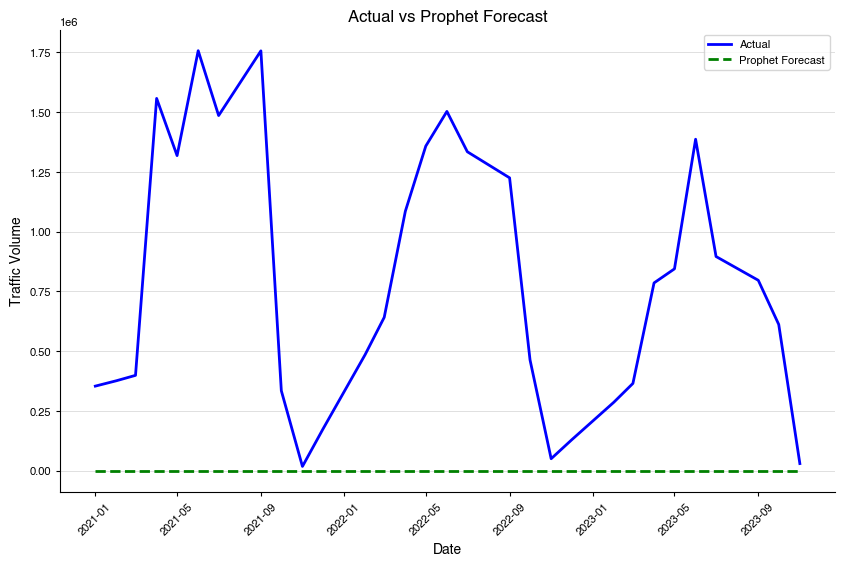

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(ptest['ds'], ptest['y'], label='Actual', color='blue', linewidth=2)
plt.plot(ptest['ds'], ptest['prophet_forecast'], label='Prophet Forecast', color='green', linestyle='--', linewidth=2)
plt.title('Actual vs Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [23]:
# Filter out zero actual values before calculating MAPE
ptest_non_zero = ptest[ptest['y'] != 0]

# Recalculate MAPE
mape_prophet_non_zero = mean_absolute_percentage_error(ptest_non_zero['y'], ptest_non_zero['prophet_forecast'])

print(f"Prophet Model MAPE (Non-zero Actuals): {mape_prophet_non_zero * 100:.2f}%")


Prophet Model MAPE (Non-zero Actuals): 100.00%


In [24]:
# Evaluate MAE and MAPE after interpolation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae_prophet = mean_absolute_error(ptest['y'], ptest['prophet_forecast'])
mape_prophet = mean_absolute_percentage_error(ptest['y'], ptest['prophet_forecast'])

print(f"Prophet Model MAE: {mae_prophet}")
# print(f"Prophet Model MAPE: {mape_prophet * 100:.2f}%")

Prophet Model MAE: 802632.8


## Model 3: XGBoost Model

### Feature Engineering for XGBoost

In [31]:
def create_dt_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
    
    # Create additional datetime features
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter
    
    X = df[['month', 'year', 'dayofweek', 'quarter']]
    
    if label:
        y = df[label]
        return X, y
    return X

In [35]:
# XGBoost model preparation
X_train, y_train = create_dt_features(ptrain, label='y')  # For training data
X_test, y_test = create_dt_features(ptest, label='y')     # For test data


In [36]:
from xgboost import XGBRegressor

# Initialize the XGBoost model
xgboost_model = XGBRegressor(
    n_estimators=1000,  # You can tune this parameter
    learning_rate=0.1,  # Initial learning rate
    early_stopping_rounds=50,  # Early stopping to avoid overfitting
    verbosity=1,
    random_state=42
)


In [37]:
# Fit the XGBoost model
xgboost_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)], 
    verbose=True
)

[0]	validation_0-rmse:944148.35349
[1]	validation_0-rmse:872080.43018
[2]	validation_0-rmse:807411.26139
[3]	validation_0-rmse:748175.86377
[4]	validation_0-rmse:699443.47994
[5]	validation_0-rmse:651923.68114
[6]	validation_0-rmse:612347.42044
[7]	validation_0-rmse:572335.34935
[8]	validation_0-rmse:540477.34542
[9]	validation_0-rmse:507868.98725
[10]	validation_0-rmse:486387.74651
[11]	validation_0-rmse:457492.23656
[12]	validation_0-rmse:434992.85998
[13]	validation_0-rmse:416717.22336
[14]	validation_0-rmse:399831.05879
[15]	validation_0-rmse:385483.30618
[16]	validation_0-rmse:375674.26507
[17]	validation_0-rmse:363763.55803
[18]	validation_0-rmse:353174.75096
[19]	validation_0-rmse:344429.09038
[20]	validation_0-rmse:339952.83801
[21]	validation_0-rmse:335402.44473
[22]	validation_0-rmse:331020.94488
[23]	validation_0-rmse:325107.31141
[24]	validation_0-rmse:317845.58317
[25]	validation_0-rmse:317059.51322
[26]	validation_0-rmse:316754.19305
[27]	validation_0-rmse:311943.96980
[2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [38]:
# Predict using the test set
y_pred_xgb = xgboost_model.predict(X_test)


In [44]:
from sklearn.metrics import mean_absolute_percentage_error

mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
print(f"XGBoost Model MAPE: {mape_xgb * 100:.2f}%")



XGBoost Model MAPE: 135.42%


## Comparison of All Models

In [43]:
# Print the MAPE for each model (Prophet, Naive, XGBoost)
print(f"MAPE (Prophet): {mape_prophet * 100:.2f}%")
print(f"MAPE (Naive): {mape_naive * 100:.2f}%")
print(f"MAPE (XGBoost): {mape_xgb * 100:.2f}%")

MAPE (Prophet): 100.00%
MAPE (Naive): 146.86%
MAPE (XGBoost): 135.42%
